In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [6]:
!python -V

Python 3.6.4 :: Anaconda, Inc.


In [3]:
cv2.__version__

'3.4.0'

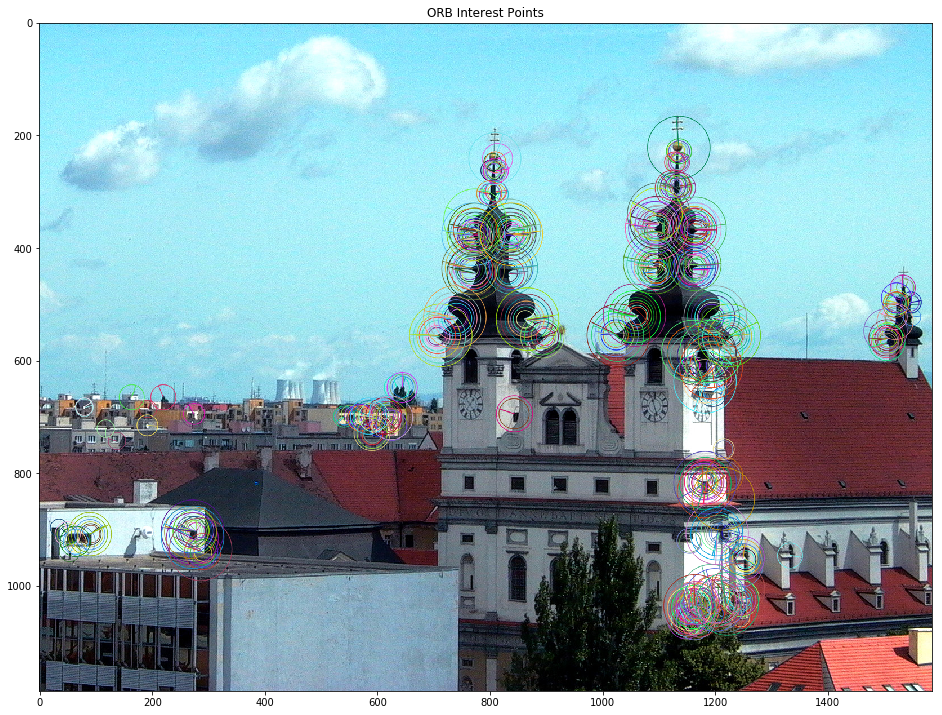

In [2]:
dataset_path = 'C:/Users/srava/Downloads/localizedata'
img_building = cv2.imread(os.path.join(dataset_path, 'building_1.jpg'))
img_building = cv2.cvtColor(img_building, cv2.COLOR_BGR2RGB)  # Convert from cv's BRG default color order to RGB

orb = cv2.ORB_create()  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.
key_points, description = orb.detectAndCompute(img_building, None)
img_building_keypoints = cv2.drawKeypoints(img_building, 
                                           key_points, 
                                           img_building, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
plt.figure(figsize=(16, 16))
plt.title('ORB Interest Points')
plt.imshow(img_building_keypoints); plt.show()

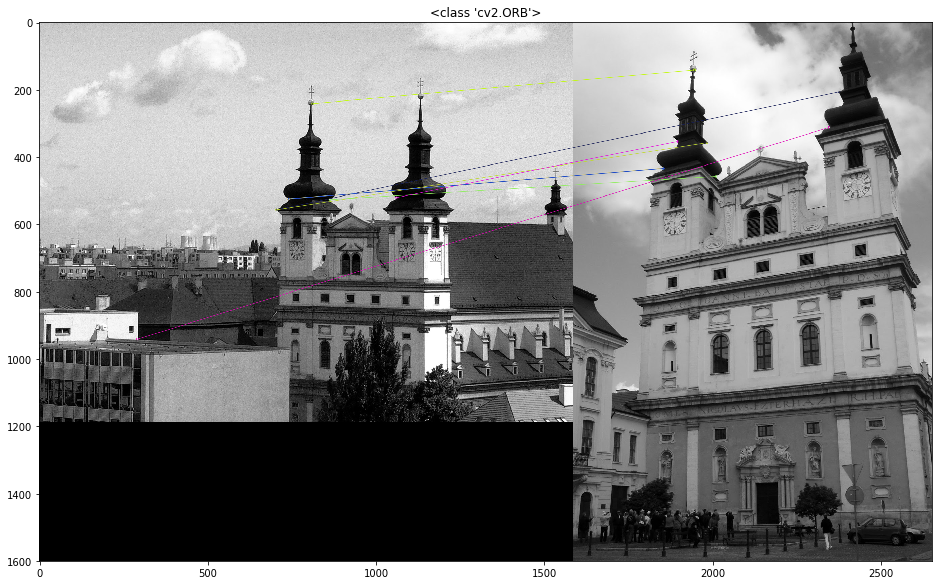

In [7]:
def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(dataset_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=10):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    plt.figure(figsize=(16, 16))
    plt.title(type(detector))
    plt.imshow(img_matches); plt.show()
    

orb = cv2.ORB_create()
draw_image_matches(orb, 'building_1.jpg', 'building_2.jpg')

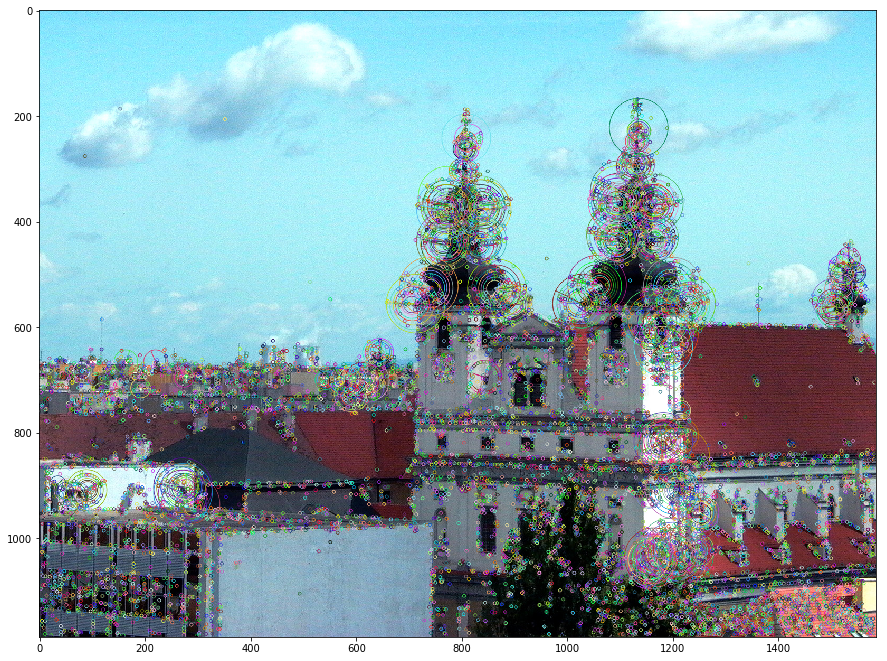

In [8]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img_building, None)
img_kp = cv2.drawKeypoints(img_building, kp, img_building)

plt.figure(figsize=(15, 15))
plt.imshow(img_kp); plt.show()

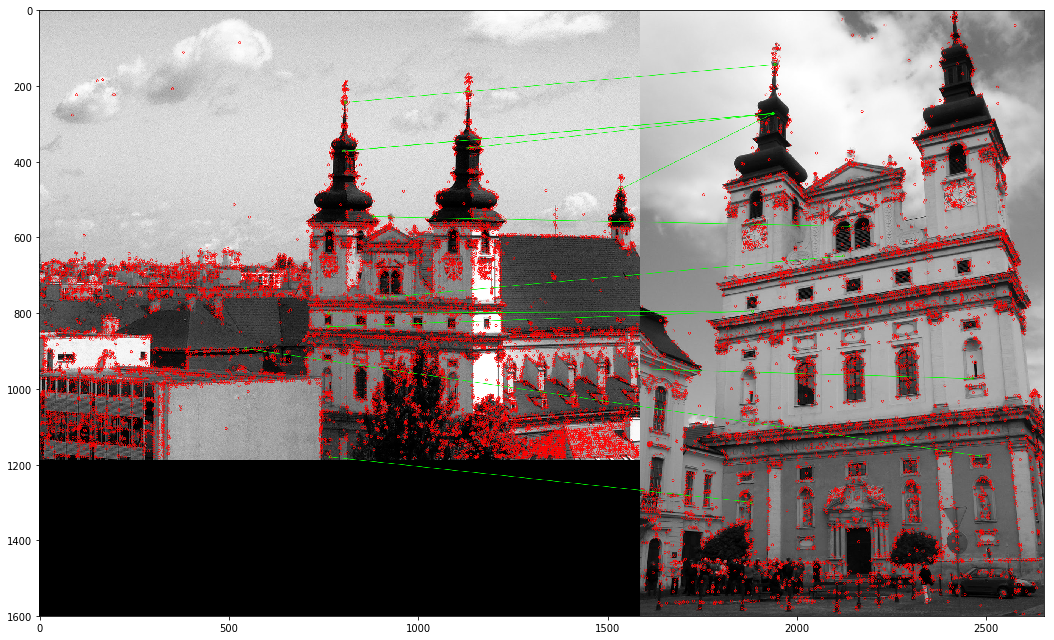

In [9]:
img1, kp1, des1 = image_detect_and_compute(sift, 'building_1.jpg')
img2, kp2, des2 = image_detect_and_compute(sift, 'building_2.jpg')

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1, des2, k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.55*n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
plt.figure(figsize=(18, 18))
plt.imshow(img3); plt.show()